In [4]:
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup as bsp
import matplotlib
import matplotlib.pyplot as plt
import sqlite3
import re
from datetime import datetime, timedelta,date
import sys

# lda 부분

In [5]:
############################### 개별 db에서 필요 항목 불러오기
def getSub():
    dbname='./stock/news_05930.db'  #여기에 상장 기업별로 통합된 db내용 넣기 
    with sqlite3.connect(dbname) as conn:
        cursor=conn.cursor()
        sql='select content from news ' # 여기에 키값 혹은 날자값 추가
        res=cursor.execute(sql).fetchall()
        result=[]
        for r in res:
            result.append(r[0])
            
    return result

In [6]:
############################### 개별 db에서 필요 항목 불러오기

# 꼬마 불러오기
from konlpy.tag import Kkma
kkma=Kkma()

# 주요 형태소만으로 이루어진 기사만들기
def getPOS(rres):
    p=kkma.pos(rres)
    dictpos={}
    words=[]
    #표제어 추출
    check=['NNG','NNP','NNB','NNM','VV','VA','VXV','VXA','VCP','VCN','SF','EFN','EFQ']
    for  w,pos in p:
        if(pos in check):
            words.append(w)
            if (w in dictpos.keys()):
                dictpos[w]+=1
            else:
                dictpos[w]=1
    return (dictpos,words)  

docs=getSub()

#하나의 주요한 형태소만으로 이루어진 기사내용(list)를 하나의 글로 만듬
def getCorpus(doc):
    getp=getPOS(doc)
    sen=' '.join(getp[1])
    return sen

# corpus라는 리스트에 개별 처리된 기사내용을 넣음 
corpus=[]
for doc in docs:
    getp=getCorpus(doc)
    corpus.append(getp)


# 카운트 기반 TDM을 만듬
    # min_df document frequency 문서내 발견 횟수
from sklearn.feature_extraction.text import CountVectorizer
vect=CountVectorizer(min_df=6,ngram_range=(1,3)) # 6번 이하로 나오는 단어는 추출X, n-gram은 1~3
tdm=vect.fit_transform(corpus).toarray()

#
words=list(vect.get_feature_names()) # fit을 통해서 vect에 학습된 피처들의 이름
i=0
for td in tdm:
    zt=list(zip(words,td))  # 피처이름 모음과 개별기사 zip -> 각 피처와 그에 해당하는 행의 값들이 처나옴
    szt=sorted(zt,key=(lambda x:x[1]),reverse=True)
    i+=1


JVMNotFoundException: No JVM shared library file (jvm.dll) found. Try setting up the JAVA_HOME environment variable properly.

## 카운트기반 : CountVectorizer

In [3]:
# 카운트 기반 TDM을 만듬
    # min_df document frequency 문서내 발견 횟수
from sklearn.feature_extraction.text import CountVectorizer
vect=CountVectorizer(min_df=6,ngram_range=(1,3)) # 6번 이하로 나오는 단어는 추출X, n-gram은 1~3
tdm=vect.fit_transform(corpus).toarray()
tdm.shape

NameError: name 'corpus' is not defined

In [6]:
# (n-gram, 출현빈도) 꼴로 변환, 리스트화
    #words=list(vect.vocabulary_.keys())# 전체 단어 갯수 파악용
words=list(vect.get_feature_names()) # fit을 통해서 vect에 학습된 피처들의 이름

i=0
for td in tdm:
    zt=list(zip(words,td))  # 피처이름 모음과 개별기사 zip -> 각 피처와 그에 해당하는 행의 값들이 처나옴
    szt=sorted(zt,key=(lambda x:x[1]),reverse=True)  #
    #print(corpus[i])
    #print(szt[:5])
    i+=1

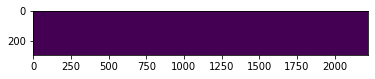

In [7]:
plt.imshow(tdm)

## 가중치기반 : TfidfVectorizer

In [8]:
# TF-IDF 방식으로 중요단어 가중치
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfv=TfidfVectorizer(min_df=6,ngram_range=(1,3))
tfm=tfidfv.fit_transform(corpus).toarray()
tfm

array([[0.04814753, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.05698422, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.04715445, 0.04569044, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.04960345, 0.03204227, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.03015971, 0.02922333, 0.0392987 , ..., 0.        , 0.        ,
        0.        ]])

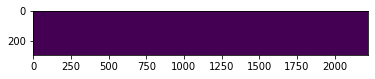

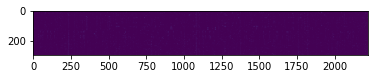

In [9]:
plt.imshow(tdm)
plt.show()
plt.imshow(tfm)
plt.show()

## LDA 이용 처리

In [10]:
### LDA
from sklearn.decomposition import LatentDirichletAllocation
lda=LatentDirichletAllocation(n_components=5)
lda.fit(tfm)
components=lda.components_
voca=list(tfidfv.get_feature_names())
print(np.shape(components))

(5, 2221)


In [10]:
# 딕셔너리를 만드는데, 토큰(n-gram)을 키로 해당 토큰의 tdidf값을 값으로 함.
def makeDict(components,voca):
    res=[]
    for c in components:
        dict={}
        for i,v in enumerate(c):
            dict[voca[i]]=v
        res.append(dict)
    return res    

In [11]:
res=makeDict(components,voca)
for r in res:
    print("*"*50)
    sr=sorted(r.items(),key=(lambda x:x[1]),reverse=True)
    print(sr[:5])

**************************************************
[('본부장', 0.849048473124392), ('프로그램', 0.6234756166330698), ('매매', 0.5608610808145792), ('영업', 0.4965988788209973), ('추진', 0.4692639256965172)]
**************************************************
[('국민', 1.6550042118087376), ('연금', 1.570781957173185), ('국민 연금', 1.5528213926199137), ('자산 운용', 0.9014158826376624), ('여의도', 0.8863907504375924)]
**************************************************
[('채용', 1.8846260322654733), ('부동산', 1.8018905561089802), ('구속', 1.6179842171032626), ('롯데', 1.530426759741282), ('대장', 1.5300755194146265)]
**************************************************
[('검찰', 1.9044427783482143), ('의혹', 1.30184587384352), ('사건', 0.8462975911929831), ('대통령', 0.646778833289404), ('전달', 0.5106473778647292)]
**************************************************
[('본부 본부장', 0.2217147490442624), ('인도', 0.020000000000343212), ('공헌', 0.020000000000000136), ('사회 공헌', 0.020000000000000122), ('디지털 혁신', 0.020000000000000052)]
***************

In [12]:
corpus_w=[]
for c in corpus:
    cs=c.split(' ')
    corpus_w.append(cs)
# corpus_w[:2]

In [13]:
from gensim import corpora
cor_dict=corpora.Dictionary(corpus_w) #사전으로 만들기
# cor_dict[1]

In [14]:
corpus_m=[]
for cor in corpus_w:
    res=cor_dict.doc2bow(cor) #doc2bow로 단어의 정수표현과 등장횟수를 알 수 있다.
    corpus_m.append(res)
# corpus_m[0]

In [15]:
import gensim
N_TOPIC=10
N_PASS=10
ldagen=gensim.models.ldamodel.LdaModel(corpus_m,num_topics=N_TOPIC,id2word=cor_dict,passes=N_PASS) 
topics=ldagen.print_topics()
# topics


In [16]:
# # import pyLDAvis.gensim  구버전 3.7이하로 예상됨
# import pyLDAvis.gensim_models
# pyLDAvis.enable_notebook()
# vis=pyLDAvis.gensim_models.prepare(ldagen,corpus_m,cor_dict)
# pyLDAvis.display(vis)

ModuleNotFoundError: No module named 'pyLDAvis.gensim_models'

### 최적의 토픽 갯수는?
* Perplexity
    - 혼란한 정도 : 낮을 수로 좋다
    - 모델간 비교에서 상대적 우위
    - 수치적 한계 -> 실제 해석상 무리가 있을 수도 있음
    
* Coherence
    - 주제의 일관성 : 높을수록 좋다
    - 주제를 이루는 단어들의 유사성으로 파악
    - 수치적 한계
    - 상대적 한계

In [17]:
# 상대적 분석
from gensim.models.coherencemodel import CoherenceModel
N_PASS=10
x=[]
ycoh=[]
yperp=[]
for i in range(2,20):
    N_TOPIC=i
    ldagen=gensim.models.ldamodel.LdaModel(corpus_m,num_topics=N_TOPIC,id2word=cor_dict,passes=N_PASS) 
    cm=CoherenceModel(model=ldagen,corpus=corpus_m,coherence='u_mass')
    coh=cm.get_coherence()
    perp=ldagen.log_perplexity(corpus_m)
    x.append(i)
    ycoh.append(coh)
    yperp.append(perp)
    print('coherence:',coh,'perpleixty:',perp)

coherence: -0.7625326436440447 perpleixty: -6.669387347115445
coherence: -0.7712797910993724 perpleixty: -6.591041551390062
coherence: -0.9447978731417948 perpleixty: -6.582246595803948
coherence: -0.8418783005885541 perpleixty: -6.543869645589661
coherence: -0.9979151660379055 perpleixty: -6.579733701300611
coherence: -1.198011586717927 perpleixty: -6.589078475210823
coherence: -2.4978683498025225 perpleixty: -6.55704830567822
coherence: -1.2386692017468421 perpleixty: -6.567448770559377
coherence: -1.1319367726350902 perpleixty: -6.565971211586085
coherence: -1.0272140177924418 perpleixty: -6.6028987789581635
coherence: -1.1119065937764854 perpleixty: -6.624680430517153
coherence: -0.9567559878573747 perpleixty: -6.581624819507254
coherence: -1.1659458849371223 perpleixty: -6.5724883830442895
coherence: -1.329397461429181 perpleixty: -6.536561962089951
coherence: -1.2081276183452625 perpleixty: -6.580876538364844
coherence: -1.3225386332586386 perpleixty: -6.593077659003606
coherence

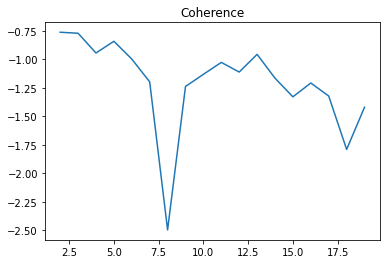

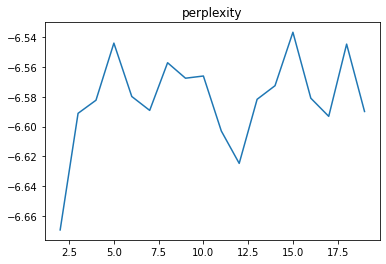

In [18]:
plt.plot(x,ycoh)
plt.title('Coherence')
plt.show()
plt.plot(x,yperp)
plt.title('perplexity')
plt.show()

In [19]:
# 상대적 분석
from gensim.models.coherencemodel import CoherenceModel
N_TOPIC=2
x=[]
ycoh=[]
yperp=[]
for i in range(2,20):
    N_PASS=i
    ldagen=gensim.models.ldamodel.LdaModel(corpus_m,num_topics=N_TOPIC,id2word=cor_dict,passes=N_PASS) 
    cm=CoherenceModel(model=ldagen,corpus=corpus_m,coherence='u_mass')
    coh=cm.get_coherence()
    perp=ldagen.log_perplexity(corpus_m)
    x.append(i)
    ycoh.append(coh)
    yperp.append(perp)
    print('coherence:',coh,'perpleixty:',perp)

coherence: -0.9980863750180466 perpleixty: -6.864288919750437
coherence: -0.8280094663551927 perpleixty: -6.694400142265081
coherence: -0.6521376879403685 perpleixty: -6.719478189371208
coherence: -0.7191840542253185 perpleixty: -6.780661269482465
coherence: -0.8078292656799373 perpleixty: -6.672526415481091
coherence: -0.7980002772286721 perpleixty: -6.671444059347466
coherence: -0.7614485911581659 perpleixty: -6.722247856576839
coherence: -0.8605350260915331 perpleixty: -6.690728522284964
coherence: -0.7544484595791996 perpleixty: -6.6824652030511835
coherence: -0.7776143721997644 perpleixty: -6.667825479288449
coherence: -0.7623201135810714 perpleixty: -6.67185188312878
coherence: -0.7696059192815163 perpleixty: -6.670974441143996
coherence: -0.7950514610938265 perpleixty: -6.690770163765349
coherence: -0.8187981655918224 perpleixty: -6.664448675565488
coherence: -0.8794772707377161 perpleixty: -6.7023905878573835
coherence: -0.8362462828207671 perpleixty: -6.670367484700771
coheren

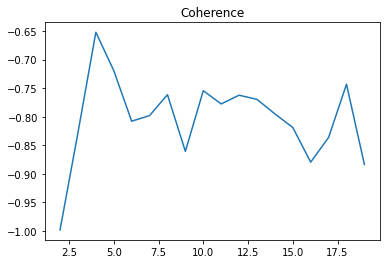

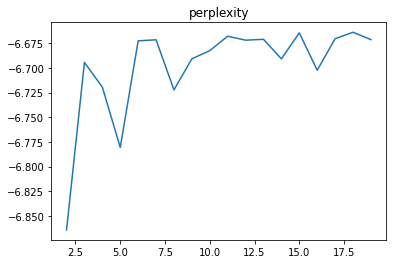

In [20]:
plt.plot(x,ycoh)
plt.title('Coherence')
plt.show()
plt.plot(x,yperp)
plt.title('perplexity')
plt.show()

In [21]:
# N_PASS=10
# N_TOPIC=2
# ldagen=gensim.models.ldamodel.LdaModel(corpus_m,num_topics=N_TOPIC,id2word=cor_dict,passes=N_PASS) 
# topics=ldagen.print_topics()
# vis=pyLDAvis.gensim_models.prepare(ldagen,corpus_m,cor_dict)
# pyLDAvis.display(vis)

# 프로잭트에 필요한 형태로 모듈화 (MergeData_tf.ipynb 기준)
    - 우리가 필요한 것 : nlp까지 반영한 주가예측

### 설명서
1. 개별 주식차트와 뉴스 db에 접속. 필요한 자료들 뽑아옴. (db의 개수가 많음.)      -> 그렇다면 그전에 해야할일이 생김: 동 기업 뉴스db 통합 or 각각 가져오는 코드
2. date 기준으로 df를 합침.
3. 그 다음 돌리면 끝



개별 설명서
1. 개별 주식차트와 뉴스 db에 접속. 필요한 자료들 뽑아옴.

### 주가, NLP합쳐진 DF만들기

In [48]:
def mergedb(code):
    db1 = './주가/{}.db'.format(code)
    db2 = './뉴스/news_{}.db'.format(code)
    with sqlite3.connect(db1) as conn:
        cur=conn.cursor()
        sql='select * from stockp'
        result1 = cur.execute(sql).fetchall()
    with sqlite3.connect(db2) as conn:
        cur=conn.cursor()
        sql='select date, content from news'
        result2 = cur.execute(sql).fetchall()
    return result1, result2

In [49]:
code = '055550'
result = mergedb(code)
result

([('2021-04-13', 37500, 37600, 36950, 37250, 1227708, 20210413),
  ('2021-04-12', 37150, 37600, 37000, 37400, 1039153, 20210412),
  ('2021-04-09', 37950, 37950, 37100, 37150, 1381576, 20210409),
  ('2021-04-08', 37800, 37800, 37350, 37400, 1578096, 20210408),
  ('2021-04-07', 37250, 37800, 37150, 37700, 1684809, 20210407),
  ('2021-04-06', 37000, 37150, 36600, 37150, 1046670, 20210406),
  ('2021-04-05', 36200, 37100, 36150, 37000, 1026596, 20210405),
  ('2021-04-02', 36600, 36950, 36100, 36350, 1296321, 20210402),
  ('2021-04-01', 37500, 37600, 36700, 36800, 1588977, 20210401),
  ('2021-03-31', 37200, 37650, 36650, 37450, 2421330, 20210331),
  ('2021-03-30', 36950, 37500, 36700, 37100, 2178506, 20210330),
  ('2021-03-29', 36650, 36900, 36150, 36900, 1997146, 20210329),
  ('2021-03-26', 36250, 36700, 36200, 36550, 2905443, 20210326),
  ('2021-03-25', 35150, 36200, 35000, 35850, 2361439, 20210325),
  ('2021-03-24', 35750, 35900, 35000, 35100, 1842963, 20210324),
  ('2021-03-23', 35700, 3

In [50]:
df1=pd.DataFrame(data=result[0],columns=['date','open','high','low','close','vol','key'])
df1['key']=df1['key'].astype(str)
df1

,date,open,high,low,close,vol,key
0,2021-04-13,37500,37600,36950,37250,1227708,20210413
1,2021-04-12,37150,37600,37000,37400,1039153,20210412
2,2021-04-09,37950,37950,37100,37150,1381576,20210409
3,2021-04-08,37800,37800,37350,37400,1578096,20210408
4,2021-04-07,37250,37800,37150,37700,1684809,20210407
...,...,...,...,...,...,...,...
885,2017-08-31,52200,52500,51500,52000,904339,20170831
886,2017-08-30,52900,52900,52300,52600,585404,20170830
887,2017-08-29,52600,53000,51600,52600,646259,20170829
888,2017-08-28,52700,53400,52200,53400,455689,20170828


In [51]:
df2=pd.DataFrame(data=result[1],columns=['date','content'])
df2['key']=df2['date'].apply(lambda x: x.strip()[0:10].replace('.','').replace('-',''))
df2['key']=df2['key']
df2 = df2.sort_values(['key'], ascending=False)
df2 = df2.reset_index(drop=True)
df2

,date,content,key
0,2020-12-30 오후 1:24:22,[이데일리 김유성 기자] ○신한금융지주 <본부장 승진>△브랜드홍보본부장 김광재 (은...,20201230
1,2020-12-23 오후 5:54:32,[이데일리 전선형 기자] 신한지주는 23일 회사인 신한생명과 오렌지라이프는 이날 양...,20201223
2,2020-12-22 오후 9:33:03,[이데일리 김윤지 기자] 서스틴베스트는 2020년 하반기 ESG(환경·사회·지배구조...,20201222
3,2020.12.22 12:03,"""KT·포스코·LG생활건강도 최고 등급 AA""""CJ대한통운·GS건설·LG유플·SKT...",20201222
4,2020.12.18 17:36,◈신한금융지주◎신규선임▷그룹 경영관리부문장(CMO) 허영택(부사장)▷그룹 브랜드홍보...,20201218
...,...,...,...
286,2018-02-07 오후 3:58:58,[이데일리 김정유 기자] 신한지주(055550)는 지난해 연결 기준으로 영업이익 3...,20180207
287,2018-02-06 오후 3:45:48,[이데일리 박일경 기자] 신한금융지주가 사외이사 및 차기 회장 후보 추천 논의에서 ...,20180206
288,2018-01-31 오후 4:52:28,[이데일리 강경훈 기자] 신한지주(055550)는 2월 7일 오후 4시 국내외 주주...,20180131
289,2018-01-24 오후 4:00:00,조용병 신한금융지주 회장. (사진=신한금융지주)[이데일리 박일경 기자] 신한금융지주...,20180124


In [52]:
df3=pd.DataFrame(columns=['key','content'])

key = df2['key'][0]
content = df2['content'][0]

for i in range(1,len(df2)):
    if df2['key'][i]==df2['key'][i-1]:
        content += df2['content'][i]
    else:
        df3.loc[i,['key','content']] = [key,content]
        key = df2['key'][i]
        content = df2['content'][i]

df3=df3.reset_index(drop=True)
df3

,key,content
0,20201230,[이데일리 김유성 기자] ○신한금융지주 <본부장 승진>△브랜드홍보본부장 김광재 (은...
1,20201223,[이데일리 전선형 기자] 신한지주는 23일 회사인 신한생명과 오렌지라이프는 이날 양...
2,20201222,[이데일리 김윤지 기자] 서스틴베스트는 2020년 하반기 ESG(환경·사회·지배구조...
3,20201218,◈신한금융지주◎신규선임▷그룹 경영관리부문장(CMO) 허영택(부사장)▷그룹 브랜드홍보...
4,20201216,신한은행의 베트남 현지법인 신한베트남은행이 호찌민과 하노이 등에 3개 지점을 추가...
...,...,...
184,20180211,주요 금융지주 및 은행들이 작년 한 해 12조5000억원에 달하는 순이익을 올리며 ...
185,20180207,[이데일리 김정유 기자] 신한지주(055550)는 지난해 연결 기준으로 영업이익 3...
186,20180206,[이데일리 박일경 기자] 신한금융지주가 사외이사 및 차기 회장 후보 추천 논의에서 ...
187,20180131,[이데일리 강경훈 기자] 신한지주(055550)는 2월 7일 오후 4시 국내외 주주...


In [147]:
df = pd.merge(df1,df3, how='left', on='key')
df

,date,open,high,low,close,vol,key,content
0,2021-04-13,37500,37600,36950,37250,1227708,20210413,NaN
1,2021-04-12,37150,37600,37000,37400,1039153,20210412,NaN
2,2021-04-09,37950,37950,37100,37150,1381576,20210409,NaN
3,2021-04-08,37800,37800,37350,37400,1578096,20210408,NaN
4,2021-04-07,37250,37800,37150,37700,1684809,20210407,NaN
...,...,...,...,...,...,...,...,...
885,2017-08-31,52200,52500,51500,52000,904339,20170831,NaN
886,2017-08-30,52900,52900,52300,52600,585404,20170830,NaN
887,2017-08-29,52600,53000,51600,52600,646259,20170829,NaN
888,2017-08-28,52700,53400,52200,53400,455689,20170828,NaN


# 합쳐진 df 한방에 돌리기

In [158]:
from konlpy.tag import Kkma
kkma=Kkma()

nlpdf=df[['date','content']].copy()
nlpdf=nlpdf.fillna('')
gtitles=nlpdf.values

def getPOS(rres,limlen=0):
    p=kkma.pos(rres)
    dictpos={}
    words=[]
    #표제어 추출
    check=['NNG','NNP','NNB','NNM','VV','VA','VXV','VXA','VCP','VCN','SF','EFN','EFQ']
    for w,pos in p:
        if(pos in check):
            if(len(w)>limlen):
                words.append(w)
                if (w in dictpos.keys()):
                    dictpos[w]+=1
                else:
                    dictpos[w]=1
    return (dictpos,words)  

# corpus라는 리스트에 개별 처리된 기사내용을 넣음 
corpus=[]
for g in gtitles:
    res=getPOS(g[1],1)
    corpus.append(' '.join(res[1]))

In [215]:
# 1) 단어 카운트 기반 TDM 데이터프레임화
from sklearn.feature_extraction.text import TfidfVectorizer
vect=TfidfVectorizer(min_df=2)
tdm=vect.fit_transform(corpus).toarray()

from sklearn.preprocessing import MinMaxScaler
mxs=MinMaxScaler()
mxtdm=mxs.fit(tdm)
mxtdm=mxs.transform(tdm)

cols=vect.get_feature_names()
cols.insert(0,'date')

tdms=[]
for i,t in enumerate(mxtdm):
    res=list(t)
    res.insert(0,gtitles[i][0])
    tdms.append(res)

tdmdf=pd.DataFrame(data=tdms, columns=cols)
tdmdf=tdmdf.set_index('date')
print('tdmdf shape : ', tdmdf.shape)

# 2) 주가 데이터 데이터프레임화
sdf=df.set_index('date').drop(['content'],axis=1)
mxs=MinMaxScaler()
mxs.fit(sdf)
outv=mxs.transform(sdf)
msdf=pd.DataFrame(outv,index=sdf.index,columns=sdf.columns)
print('msdf shape : ', msdf.shape)
print('max:',np.max(mxs.data_max_),'min:',np.min(mxs.data_min_),'n:',mxs.n_samples_seen_)

# 3) 단어+주가 데이터 병합
mergedf=pd.merge(msdf,tdmdf,left_index=True,right_index=True)
print('mergedf shape : ', mergedf.shape)

tdmdf shape :  (890, 2722)
msdf shape :  (890, 6)
max: 20210413.0 min: 21850.0 n: 890
mergedf shape :  (890, 2728)


In [216]:
##### tensorflow 임포트
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,LSTM,Conv2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [226]:
# 1) predict : NLP+주가 모두 반영

winsize=5
x_data=[]
y_data=[]
for i in range(len(mergedf)-winsize):
    x_data.append(mergedf.iloc[i:winsize+i])
    y_data.append(mergedf.iloc[winsize+i,3])
x_data=np.array(x_data).astype('float32')
y_data=np.array(y_data).astype('float32')

model=Sequential()
model.add(LSTM(128,input_shape=(winsize,mergedf.shape[1],)))
model.add(Dense(64,activation ="linear"))
model.add(Dense(1,activation="linear"))
model.compile(optimizer="sgd",loss="mse",metrics=['cosine_proximity'])
print('predict model:', model.summary())

model.fit(x_data,y_data,epochs=10) #winsize 기간 데이터 -> 지도학습
max=np.max(mxs.data_max_)

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_30 (LSTM)               (None, 128)               1462784   
_________________________________________________________________
dense_56 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_57 (Dense)             (None, 1)                 65        
Total params: 1,471,105
Trainable params: 1,471,105
Non-trainable params: 0
_________________________________________________________________
predict model: None
Epoch 1/10
28/28 [==============================] - 2s 36ms/step - loss: 0.1497 - cosine_proximity: 0.8948
Epoch 2/10
28/28 [==============================] - 1s 21ms/step - loss: 0.0187 - cosine_proximity: 0.9984
Epoch 3/10
28/28 [==============================] - 1s 19ms/step - loss: 0.0120 - cosine_proximity: 0.9977
Epoch 4/10
28/28 [==============

In [230]:
# 2) r-predict : 주가만 반영

x_data2=[]
y_data2=[]
for i in range(len(mergedf)-winsize):
    x_data2.append(mergedf.iloc[i:winsize+i,0:5])
    y_data2.append(mergedf.iloc[winsize+i,3])
x_data2=np.array(x_data2).astype('float32')
y_data2=np.array(y_data2).astype('float32')

model2=Sequential()
model2.add(LSTM(128,input_shape=(winsize,msdf.shape[1]-1,))) # key 컬럼 제외
model2.add(Dense(64,activation ="linear"))
model2.add(Dense(1,activation="linear"))
model2.compile(optimizer="sgd",loss="mse",metrics=['cosine_proximity'])
print('r-predict model:', model2.summary())
model2.fit(x_data2,y_data2,epochs=10)

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_34 (LSTM)               (None, 128)               68608     
_________________________________________________________________
dense_64 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_65 (Dense)             (None, 1)                 65        
Total params: 76,929
Trainable params: 76,929
Non-trainable params: 0
_________________________________________________________________
r-predict model: None
Epoch 1/10
28/28 [==============================] - 4s 5ms/step - loss: 0.1071 - cosine_proximity: 0.9803
Epoch 2/10
28/28 [==============================] - 0s 4ms/step - loss: 0.0080 - cosine_proximity: 0.9998
Epoch 3/10
28/28 [==============================] - 0s 4ms/step - loss: 0.0057 - cosine_proximity: 0.9990
Epoch 4/10
28/28 [=====================

In [231]:
# 3) NLP-predict : NLP만 반영

x_data3=[]
y_data3=[]
for i in range(len(mergedf)-winsize):
    x_data3.append(mergedf.iloc[i:winsize+i,6:])
    y_data3.append(mergedf.iloc[winsize+i,3])
x_data3=np.array(x_data3).astype('float32')
y_data3=np.array(y_data3).astype('float32')

model3=Sequential()
model3.add(LSTM(128,input_shape=(winsize,tdmdf.shape[1],)))
model3.add(Dense(64,activation ="linear"))
model3.add(Dense(1,activation="linear"))
model3.compile(optimizer="sgd",loss="mse",metrics=['cosine_proximity'])
print('NLP-predict model:', model3.summary())

model3.fit(x_data3,y_data3,epochs=10)

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_35 (LSTM)               (None, 128)               1459712   
_________________________________________________________________
dense_66 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_67 (Dense)             (None, 1)                 65        
Total params: 1,468,033
Trainable params: 1,468,033
Non-trainable params: 0
_________________________________________________________________
NLP-predict model: None
Epoch 1/10
28/28 [==============================] - 2s 36ms/step - loss: 0.1803 - cosine_proximity: 0.8748
Epoch 2/10
28/28 [==============================] - 1s 19ms/step - loss: 0.0542 - cosine_proximity: 0.9999
Epoch 3/10
28/28 [==============================] - 1s 19ms/step - loss: 0.0519 - cosine_proximity: 0.9980
Epoch 4/10
28/28 [==========

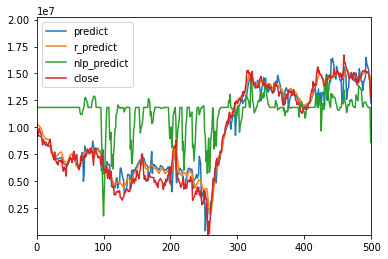

In [232]:
# 예측 & 시각화

predict=model.predict(x_data)*max
r_predict=model2.predict(x_data2)*max
nlp_predict=model3.predict(x_data3)*max
closep=mergedf['close'].values[5:]*max

plt.plot(predict ,label='predict')
plt.plot(r_predict ,label='r_predict')
plt.plot(nlp_predict ,label='nlp_predict')
plt.plot(closep,label='close')

plt.legend()
plt.xlim(0,500)
plt.ylim(np.min(mxs.data_min_),np.max(mxs.data_max_))
plt.show()

In [ ]:
# plt.plot(r_predict ,label='r_predict')
# plt.plot(predict ,label='predict')
# plt.plot(closep,label='close')
# plt.legend()
# plt.xlim(200,250)
# plt.ylim(np.min(mxs.data_min_),np.max(mxs.data_max_)/2)
# plt.show()

In [ ]:
# plt.plot(r_predict ,label='r_predict')
# plt.plot(predict ,label='predict')
# plt.plot(closep,label='close')
# plt.legend()
# plt.xlim(270,300)
# plt.ylim(np.min(mxs.data_min_),np.max(mxs.data_max_)/1.3)
# plt.show()

# 추가적인 부분
- 지금까지 한 것 모델만들기 : 이제 시험과 검증이 남음.

- 기간 조정 : 3년치 데이터 :2021년 전까지 -> train/
                          2021년 이후 -> test/

In [96]:
metric = tf.keras.metrics.BinaryAccuracy()
acc = metric(y_true, y_pred)
print(acc)

NameError: name 'tf' is not defined